# SHAP

#### Import the libraries

In [1]:
import xgboost
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load JS visualization code to notebook
shap.initjs()

#### Read the data

In [3]:
# read the data
df = pd.read_csv('../data/total_dry_no_info.csv', index_col=0)

/home/geanderson/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,4,5,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Normalize the dataset

In [4]:
# delete unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# convert all columns of DataFrame
df = df.dropna()
# find the objects columns
cols = df.columns[df.dtypes.eq('object')]
# convert to numeric these columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [5]:
df.shape

(601076, 47)

In [6]:
df.columns

Index(['comment_count', 'total_deletions', 'total_additions', 'total',
       'private', 'fork', 'size', 'has_issues', 'has_downloads', 'has_wiki',
       'forks', 'open_issues', 'watchers', 'network_count', 'admin', 'push',
       'pull', 'language_C', 'language_C#', 'language_C++', 'language_CSS',
       'language_CoffeeScript', 'language_Go', 'language_Java',
       'language_JavaScript', 'language_PHP', 'language_Perl',
       'language_Python', 'language_R', 'language_Ruby', 'language_Scala',
       'language_Shell', 'language_TypeScript', 'type_Organization',
       'type_User', 'total_files', 'is_weekend', 'is_night',
       'outside_contribution', 'tests_included', 'most_changes_added',
       'most_changes_modified', 'most_changes_removed', 'most_changes_renamed',
       'most_changes_unknown', 'phases_project', 'mean_commits'],
      dtype='object')

In [7]:
df = df[df['language_PHP'] == 1]

In [8]:
df.shape

(77864, 47)

In [9]:
df.drop('network_count', axis=1, inplace=True)
df.drop('forks', axis=1, inplace=True)
df.drop('size', axis=1, inplace=True)
#df.drop('watchers', axis=1, inplace=True)
df.drop('has_wiki', axis=1, inplace=True)

In [10]:
# dropping the columns that we do not need
#df.drop('language_C', axis=1, inplace=True)
#df.drop('language_C#', axis=1, inplace=True)
#df.drop('language_C++', axis=1, inplace=True)
#df.drop('language_CSS', axis=1, inplace=True)
#df.drop('language_CoffeeScript', axis=1, inplace=True)
#df.drop('language_Go', axis=1, inplace=True)
#df.drop('language_Java', axis=1, inplace=True)
#df.drop('language_JavaScript', axis=1, inplace=True)
#df.drop('language_PHP', axis=1, inplace=True)
#df.drop('language_Perl', axis=1, inplace=True)
#df.drop('language_Python', axis=1, inplace=True)
#df.drop('language_R', axis=1, inplace=True)
#df.drop('language_Ruby', axis=1, inplace=True)
#df.drop('language_Scala', axis=1, inplace=True)
#df.drop('language_Shell', axis=1, inplace=True)
#df.drop('language_TypeScript', axis=1, inplace=True)
#df.drop('network_count', axis=1, inplace=True)
#df.drop('forks', axis=1, inplace=True)

In [11]:
# separating X and y
cols = [col for col in df.columns if col not in ['mean_commits']]
X = df[cols]
y = df['mean_commits']

In [12]:
# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

/home/geanderson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/geanderson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [13]:
# explain the model's predictions using SHAP values.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

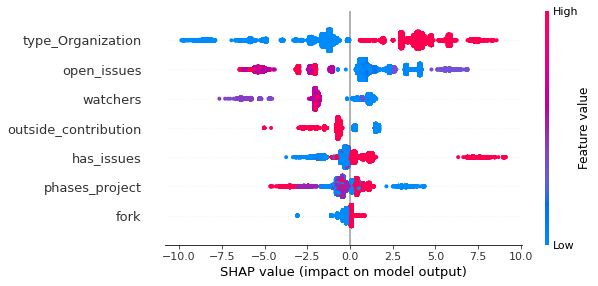

In [14]:
shap.summary_plot(shap_values, X, max_display=7)

In [15]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
#shap.dependence_plot("phases_project", shap_values, X)

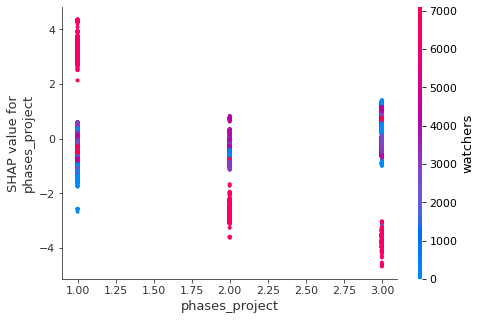

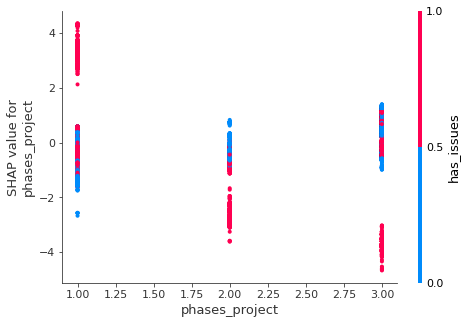

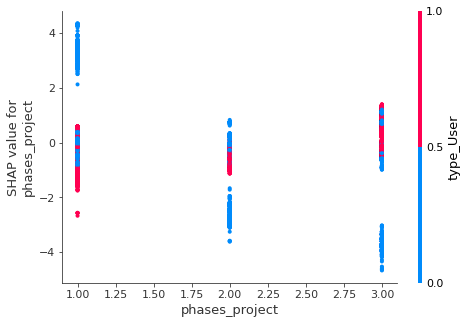

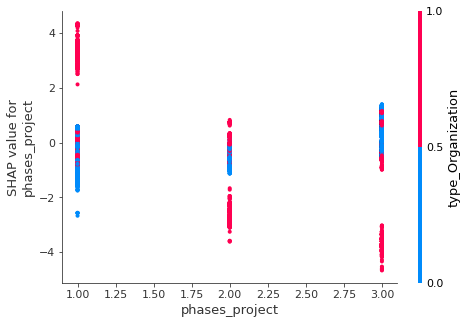

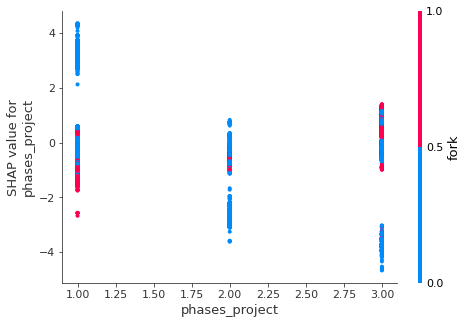

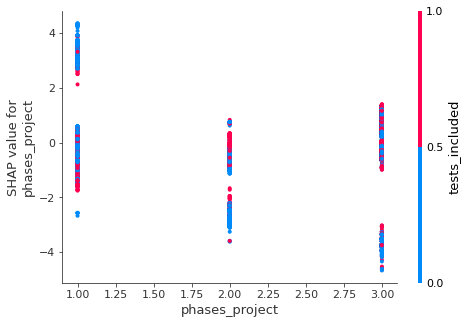

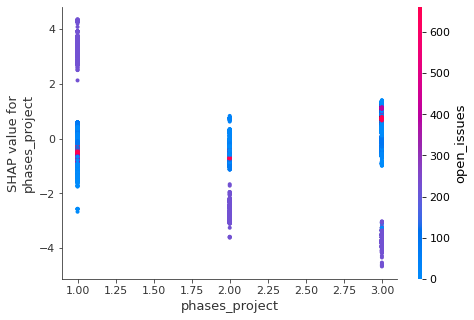

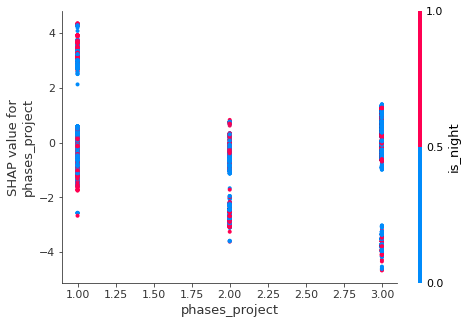

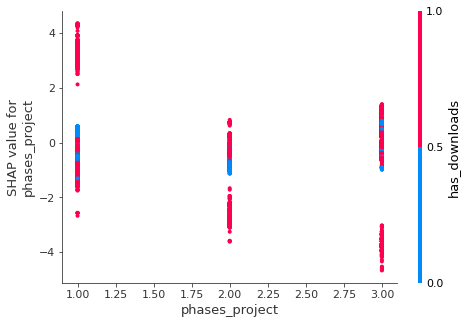

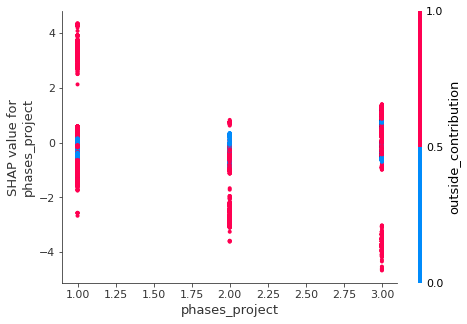

In [16]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("phases_project", shap_values, X)

# make plots colored by each of the top three possible interacting features
for i in range(10):
    shap.dependence_plot("phases_project", shap_values, X, interaction_index=inds[i])

#### That's all folks!